# DL HW1

In [2]:
# import zipfile
# import os, glob, shutil
import numpy as np
import pandas as pd
from imageio import imread, imwrite
# from skimage.transform import resize   #作業不能用這個套件
import matplotlib.pyplot as plt
from PIL import Image
# from scipy.spatial.distance import pdist, squareform
import time
import cv2
from time import sleep
from tqdm import tqdm, trange
import multiprocessing
from multiprocessing import Pool
from skimage import feature, data, color
import skimage

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F

from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron

from functools import partial

from sklearn.ensemble import RandomForestClassifier
import xgboost
# from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier#, Pool
# import category_encoders as ce
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from random import shuffle
# from sklearn.model_selection import KFold

import mahotas
# import argparse

import skimage.feature as skif
# import skimage.io as skio
# from skimage.feature import greycomatrix, greycoprops
import skimage

import pywt
import pywt.data
import heapq

%autosave 120

/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Autosaving every 120 seconds


In [4]:
cpus = multiprocessing.cpu_count()
print(cpus)
print(torch.cuda.is_available()) 

160
True


In [3]:
# 讀取index
train_idx = pd.read_table('train.txt', header = None, sep = ' ')
val_idx = pd.read_table('val.txt', header = None, sep = ' ')
test_idx = pd.read_table('test.txt', header = None, delimiter = ' ')
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
print(train_idx.shape)
print(val_idx.shape)
print(test_idx.shape)
print(train_idx[:3])
print(train_y[:3])

(63325, 2)
(450, 2)
(450, 2)
[['images/n02111277/n02111277_10005.JPEG' 0]
 ['images/n02111277/n02111277_10019.JPEG' 0]
 ['images/n02111277/n02111277_10072.JPEG' 0]]
[0. 0. 0.]


## Read Data

In [4]:
# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img

In [150]:
# 讀取圖片
# 2 mins
s = time.time()
if __name__ == '__main__' : 
    with Pool(processes = 80) as p:
        train_pic = list(tqdm(p.imap(read_img, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
        val_pic = list(tqdm(p.imap(read_img, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
        test_pic = list(tqdm(p.imap(read_img, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))
print(time.time() - s)

100%|██████████| 450/450 [00:00<00:00, 996.56it/s]


123.60227537155151


In [8]:
# 存np.array
s = time.time()
train_pic = np.array(train_pic)
print(train_pic.shape)
np.save('./data/train_pic', train_pic)

val_pic = np.array(val_pic)
print(val_pic.shape)
np.save('./data/val_pic', val_pic)

test_pic = np.array(test_pic)
print(test_pic.shape)
np.save('./data/test_pic', test_pic)

print(time.time() - s)

(63325, 256, 256, 3)
(450, 256, 256, 3)
(450, 256, 256, 3)
14.82349419593811


In [52]:
# 20 s
s = time.time()
train_pic = np.load('./data/train_pic.npy')
val_pic = np.load('./data/val_pic.npy')
test_pic = np.load('./data/test_pic.npy')
print(time.time() - s)

5.081888675689697


In [9]:
# 2 min
s = time.time()
train_pic_list = list(train_pic)
val_pic_list = list(val_pic)
test_pic_list = list(test_pic)
print(train_pic.dtype)
print(time.time() - s)

uint8
0.013334989547729492


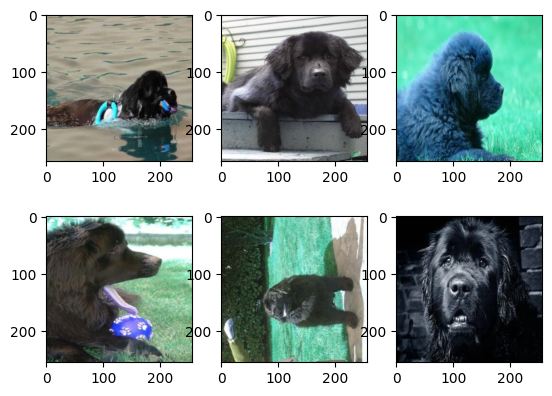

In [10]:
# print img
plt.subplot(2, 3, 1)
img = Image.fromarray(train_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 2)
img = Image.fromarray(val_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 3)
img = Image.fromarray(test_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 4)
img = Image.fromarray(train_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 5)
img = Image.fromarray(val_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 6)
img = Image.fromarray(test_pic[1].astype(np.uint8))
plt.imshow(img)

## Feature Extraction

### Color Histogram

In [23]:
# color histogram
def color_histogram(img, hist_size = 256):
    img = img.astype(np.uint8)
    color = ('b','g','r')
    histogram = []
    for idx, color in enumerate(color):
        h = cv2.calcHist(img,[idx],None,[hist_size],[0, 256])
        histogram.append(h)
    
    return np.array(histogram).squeeze().reshape(1, -1)
img = train_pic[0]
h = color_histogram(img)
print(type(h))
print(h.shape)

<class 'numpy.ndarray'>
(1, 768)


In [161]:
# color histogram
# 9 mins
s = time.time()
func = partial(color_histogram, hist_size = 64)
with Pool(processes = 40) as p:
    train_x_color_hist = list(tqdm(p.imap(func, train_pic_list, chunksize=1000), total = train_idx.shape[0]))
    val_x_color_hist = list(tqdm(p.imap(func, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_color_hist = list(tqdm(p.imap(func, test_pic_list, chunksize=100), total = test_idx.shape[0]))
    
train_x_color_hist = np.array(train_x_color_hist)
val_x_color_hist = np.array(val_x_color_hist)
test_x_color_hist = np.array(test_x_color_hist)
print(train_x_color_hist.shape)
print(val_x_color_hist.shape)
print(test_x_color_hist.shape)
print(time.time() - s)

100%|██████████| 450/450 [00:01<00:00, 249.47it/s]


(63325, 1, 192)
(450, 1, 192)
(450, 1, 192)
511.9201316833496


In [166]:
train_x_color_hist = train_x_color_hist.squeeze()
val_x_color_hist = val_x_color_hist.squeeze()
test_x_color_hist = test_x_color_hist.squeeze()
print(train_x_color_hist.shape)

(63325, 192)


In [12]:
np.save('./data/train_x_color_hist', train_x_color_hist)
np.save('./data/val_x_color_hist', val_x_color_hist)
np.save('./data/test_x_color_hist', test_x_color_hist)

In [53]:
train_x_color_hist = np.load('./data/train_x_color_hist.npy')
val_x_color_hist = np.load('./data/val_x_color_hist.npy')
test_x_color_hist = np.load('./data/test_x_color_hist.npy')

### HOG : Histogram of oriented gradients

In [6]:
def get_hog_feature(img) :
    img = img.astype(np.uint8)
    hog_vec, hog_vis = feature.hog(img, 
                               pixels_per_cell=(64, 64), 
                               cells_per_block = [1, 1],
                               channel_axis = 2, 
                               visualize=True)
    return hog_vec
img = train_pic[0]
h = get_hog_feature(img)
print(type(h))
print(h.shape)

<class 'numpy.ndarray'>
(144,)


In [14]:
# hog
# 6 mins
s = time.time()
# func = partial(color_histogram, hist_size = 64)
with Pool(processes = 40) as p:
    train_x_hog = list(tqdm(p.imap(get_hog_feature, train_pic_list, chunksize=100), total = train_idx.shape[0]))
    val_x_hog = list(tqdm(p.imap(get_hog_feature, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_hog = list(tqdm(p.imap(get_hog_feature, test_pic_list, chunksize=100), total = test_idx.shape[0])) 
train_x_hog = np.array(train_x_hog)
val_x_hog = np.array(val_x_hog)
test_x_hog = np.array(test_x_hog)
print(train_x_hog.shape)
print(val_x_hog.shape)
print(test_x_hog.shape)
print(time.time() - s)

100%|██████████| 450/450 [00:03<00:00, 122.21it/s]


(63325, 144)
(450, 144)
(450, 144)
304.76165199279785


In [14]:
np.save('./data/train_x_hog', train_x_hog)
np.save('./data/val_x_hog', val_x_hog)
np.save('./data/test_x_hog', test_x_hog)

In [54]:
s = time.time()
train_x_hog = np.load('./data/train_x_hog.npy')
val_x_hog = np.load('./data/val_x_hog.npy')
test_x_hog = np.load('./data/test_x_hog.npy')
print(time.time() - s)

0.0479893684387207


### Haralick Texture

In [34]:
def get_haralick(img): 
    values_temp = []
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = skimage.feature.graycomatrix(img, [2, 8, 16], [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4], 256, symmetric=True, normed=True)  # , np.pi / 4, np.pi / 2, np.pi * 3 / 4
    # print(glcm.shape) 
    for prop in {'contrast', 'dissimilarity','homogeneity', 'energy', 'correlation', 'ASM'}:
        temp = skimage.feature.graycoprops(glcm, prop)
        temp = np.array(temp).reshape(-1)
        values_temp.append(temp)
        # print(prop, temp)
        # print('len:',len(temp))
        # print('')
    values_temp = np.array(values_temp).reshape(1, -1)
    return (values_temp)

img = train_pic[0].astype(np.uint8)
h = get_haralick(img)
print(h.shape)
print(type(h))
# print(h)


(1, 72)
<class 'numpy.ndarray'>


In [35]:
# haralick
# 7 mins
s = time.time()
with Pool(40) as p:
    train_x_haralick = list(tqdm(p.imap(get_haralick, train_pic_list, chunksize=100), total = train_idx.shape[0]))
    val_x_haralick = list(tqdm(p.imap(get_haralick, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_haralick = list(tqdm(p.imap(get_haralick, test_pic_list, chunksize=100), total = test_idx.shape[0])) 
train_x_haralick = np.array(train_x_haralick)
val_x_haralick = np.array(val_x_haralick)
test_x_haralick = np.array(test_x_haralick)
print(train_x_haralick.shape)
print(val_x_haralick.shape)
print(test_x_haralick.shape)
print(time.time() - s)

100%|██████████| 450/450 [00:09<00:00, 49.76it/s]


(63325, 1, 72)
(450, 1, 72)
(450, 1, 72)
327.6389501094818


In [36]:
train_x_haralick = train_x_haralick.squeeze()
val_x_haralick = val_x_haralick.squeeze()
test_x_haralick = test_x_haralick.squeeze()
print(train_x_haralick.shape)

(63325, 72)


In [16]:
np.save('./data/train_x_haralick', train_x_haralick)
np.save('./data/val_x_haralick', val_x_haralick)
np.save('./data/test_x_haralick', test_x_haralick)

In [55]:
train_x_haralick = np.load('./data/train_x_haralick.npy')
val_x_haralick = np.load('./data/val_x_haralick.npy')
test_x_haralick = np.load('./data/test_x_haralick.npy')

### Wavelet Transform

In [37]:
def get_wavelet(img, want = 'LH') : 
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    coeffs2 = pywt.dwt2(img, 'haar', axes = (0, 1))
    LL, (LH, HL, HH) = coeffs2
    if want == 'LL' :
        a = LL
    elif want == 'LH' :
        a = LH
    elif want == 'HL' :
        a = HL
    else : 
        a = HH
    temp = a/np.abs(a).max()
    return temp
img = train_pic[0]
w = get_wavelet(img)
print(type(w))
print(w.shape)

<class 'numpy.ndarray'>
(128, 128)


In [39]:
# wavelet
# 6 min
s = time.time()
func = partial(get_wavelet, want = 'LH')
with Pool(processes = 16) as p:
    train_x_wavelet = list(tqdm(p.imap(func, train_pic_list, chunksize=1000), total = train_idx.shape[0]))
    val_x_wavelet = list(tqdm(p.imap(func, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_wavelet = list(tqdm(p.imap(func, test_pic_list, chunksize=100), total = test_idx.shape[0]))
    
train_x_wavelet = np.array(train_x_wavelet)
val_x_wavelet = np.array(val_x_wavelet)
test_x_wavelet = np.array(test_x_wavelet)
print(train_x_wavelet.shape)
print(val_x_wavelet.shape)
print(test_x_wavelet.shape)
print(time.time() - s)

100%|██████████| 450/450 [00:01<00:00, 233.78it/s]


(63325, 128, 128)
(450, 128, 128)
(450, 128, 128)
288.9422562122345


In [18]:
np.save('./data/train_x_wavelet', train_x_wavelet)
np.save('./data/val_x_wavelet', val_x_wavelet)
np.save('./data/test_x_wavelet', test_x_wavelet)

In [56]:
train_x_wavelet = np.load('./data/train_x_wavelet.npy')
val_x_wavelet = np.load('./data/val_x_wavelet.npy')
test_x_wavelet = np.load('./data/test_x_wavelet.npy')

### Concat Features 

In [11]:
# color hist 192
# hog 144
# haralick 72

train_x = np.concatenate([train_x_color_hist, train_x_hog, train_x_haralick], axis = 1)
val_x = np.concatenate([val_x_color_hist, val_x_hog, val_x_haralick], axis = 1)
test_x = np.concatenate([test_x_color_hist, test_x_hog, test_x_haralick], axis = 1)

print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(63325, 408)
(450, 408)
(450, 408)


In [20]:
np.save('./data/train_x', train_x)
np.save('./data/val_x', val_x)
np.save('./data/test_x', test_x)

In [19]:
train_x = np.load('./data/train_x.npy')
val_x = np.load('./data/val_x.npy')
test_x = np.load('./data/test_x.npy')

## Model

In [5]:
train_x = np.load('./data/train_x.npy')
val_x = np.load('./data/val_x.npy')
test_x = np.load('./data/test_x.npy')

In [6]:
def top_n_acc(prob, label, n = 5) :
    acc = []
    prob = np.array(prob)
    label = np.array(label)
    label = label[:, np.newaxis]
    temp = prob.argsort(axis = 1)[::, -n:]
    temp = np.hstack([temp, label])
    for i in range(label.shape[0]) :
        a = len(np.unique(temp[i, ::]))
        a = np.where(a == n, 1, 0)
        acc.append(a)
    acc = np.array(acc)
    return acc.mean()
    
    

### Perceptron

In [14]:
s = time.time()

clf = Perceptron(tol=1e-5, n_jobs = 40, early_stopping = True, warm_start = True, max_iter = 2000)
clf.fit(train_x, train_y )

print('訓練集: ', clf.score(train_x, train_y))
print('驗證集: ', clf.score(val_x, val_y))
print('測試集: ', clf.score(test_x, test_y))

print(time.time() - s)

訓練集:  0.05009080142123964
驗證集:  0.051111111111111114
測試集:  0.044444444444444446
3.1247918605804443


### Random Forest Classifier (scikit-learning)

In [16]:
#  random forest 
s = time.time()

forest = RandomForestClassifier(n_estimators = 100, n_jobs = 40)
forest.fit(train_x, train_y)

print('訓練集: ', metrics.accuracy_score(train_y, forest.predict(train_x)))
print('驗證集: ', metrics.accuracy_score(val_y, forest.predict(val_x)))
print('測試集: ', metrics.accuracy_score(test_y, forest.predict(test_x)))

train_y_pred = forest.predict_proba(train_x)
val_y_pred = forest.predict_proba(val_x)
test_y_pred = forest.predict_proba(test_x)

print(time.time() - s)

訓練集:  0.9952625345440189
驗證集:  0.11555555555555555
測試集:  0.10888888888888888
9.407518148422241


In [17]:
print('訓練集 top 1 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 1), 4))
print('驗證集 top 1 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 1), 4))
print('測試集 top 1 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 1), 4))
print('訓練集 top 5 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 5), 4))
print('驗證集 top 5 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 5), 4))
print('測試集 top 5 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 5), 4))

訓練集 top 1 acc :  0.9953
驗證集 top 1 acc :  0.1267
測試集 top 1 acc :  0.1133
訓練集 top 5 acc :  1.0
驗證集 top 5 acc :  0.3711
測試集 top 5 acc :  0.3622


### XGBoost

In [18]:
# 4 mins
s = time.time()

clf = XGBClassifier(n_jobs = 80)
clf.fit(train_x, train_y)

print('訓練集: ', clf.score(train_x, train_y))
print('驗證集: ', clf.score(val_x, val_y))
print('測試集: ', clf.score(test_x, test_y))

train_y_pred = clf.predict_proba(train_x)
val_y_pred = clf.predict_proba(val_x)
test_y_pred = clf.predict_proba(test_x)

print(time.time() - s)

訓練集:  0.9763758389261745
驗證集:  0.1511111111111111
測試集:  0.1511111111111111
238.73171186447144


In [19]:
print('訓練集 top 1 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 1), 4))
print('驗證集 top 1 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 1), 4))
print('測試集 top 1 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 1), 4))
print('訓練集 top 5 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 5), 4))
print('驗證集 top 5 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 5), 4))
print('測試集 top 5 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 5), 4))

訓練集 top 1 acc :  0.9764
驗證集 top 1 acc :  0.1511
測試集 top 1 acc :  0.1511
訓練集 top 5 acc :  0.9982
驗證集 top 5 acc :  0.4222
測試集 top 5 acc :  0.4067


### CatBoost

In [20]:
# 20 mins
s = time.time()

clf = CatBoostClassifier(iterations=2000, eval_metric = 'Accuracy', verbose = 400 , thread_count = 80)
clf.fit(train_x, train_y, eval_set = (val_x, val_y))

print('訓練集: ', clf.score(train_x, train_y))
print('驗證集: ', clf.score(val_x, val_y))
print('測試集: ', clf.score(test_x, test_y))

train_y_pred = clf.predict_proba(train_x)
val_y_pred = clf.predict_proba(val_x)
test_y_pred = clf.predict_proba(test_x)

print(time.time() - s)

Learning rate set to 0.090026
0:	learn: 0.0617450	test: 0.0511111	best: 0.0511111 (0)	total: 659ms	remaining: 21m 56s
400:	learn: 0.2918437	test: 0.1644444	best: 0.1733333 (357)	total: 3m 20s	remaining: 13m 17s
800:	learn: 0.3520095	test: 0.1822222	best: 0.1844444 (539)	total: 7m 12s	remaining: 10m 46s
1200:	learn: 0.4042637	test: 0.1844444	best: 0.1955556 (1069)	total: 11m 9s	remaining: 7m 25s
1600:	learn: 0.4508804	test: 0.1822222	best: 0.1955556 (1069)	total: 15m 8s	remaining: 3m 46s
1999:	learn: 0.5000869	test: 0.1955556	best: 0.2000000 (1822)	total: 19m 9s	remaining: 0us

bestTest = 0.2
bestIteration = 1822

Shrink model to first 1823 iterations.
訓練集:  0.4789577575996842
驗證集:  0.2
測試集:  0.19777777777777777
1170.7032353878021


In [21]:
print('訓練集 top 1 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 1), 4))
print('驗證集 top 1 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 1), 4))
print('測試集 top 1 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 1), 4))
print('訓練集 top 5 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 5), 4))
print('驗證集 top 5 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 5), 4))
print('測試集 top 5 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 5), 4))

訓練集 top 1 acc :  0.479
驗證集 top 1 acc :  0.2
測試集 top 1 acc :  0.1978
訓練集 top 5 acc :  0.7827
驗證集 top 5 acc :  0.4956
測試集 top 5 acc :  0.4756


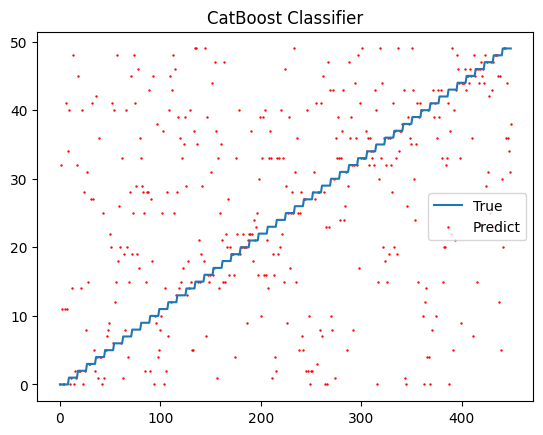

In [22]:
pred = clf.predict(test_x)
plt.title('CatBoost Classifier')
plt.plot(range(pred.shape[0]), val_y, label="True")
plt.scatter(range(pred.shape[0]), pred, label="Predict", s = 0.5, c = 'red')
plt.legend()
plt.show()

### LightGBM

In [23]:
s = time.time()

clf = lgb.LGBMClassifier(objective = 'multiclass', 
                                learning_rate = 1e-2, 
                                n_estimators = 100, 
                                n_jobs = 80)
clf.fit(train_x, train_y)

print('訓練集: ', clf.score(train_x, train_y))
print('驗證集: ', clf.score(val_x, val_y))
print('測試集: ', clf.score(test_x, test_y))

train_y_pred = clf.predict_proba(train_x)
val_y_pred = clf.predict_proba(val_x)
test_y_pred = clf.predict_proba(test_x)

print(time.time() - s)

訓練集:  0.5195894196604817
驗證集:  0.13111111111111112
測試集:  0.14
151.2506811618805


In [24]:
print('訓練集 top 1 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 1), 4))
print('驗證集 top 1 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 1), 4))
print('測試集 top 1 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 1), 4))
print('訓練集 top 5 acc : ', round(top_n_acc(prob = train_y_pred, label = train_y, n = 5), 4))
print('驗證集 top 5 acc : ', round(top_n_acc(prob = val_y_pred, label = val_y, n = 5), 4))
print('測試集 top 5 acc : ', round(top_n_acc(prob = test_y_pred, label = test_y, n = 5), 4))

訓練集 top 1 acc :  0.5196
驗證集 top 1 acc :  0.1311
測試集 top 1 acc :  0.14
訓練集 top 5 acc :  0.7297
驗證集 top 5 acc :  0.4022
測試集 top 5 acc :  0.3867


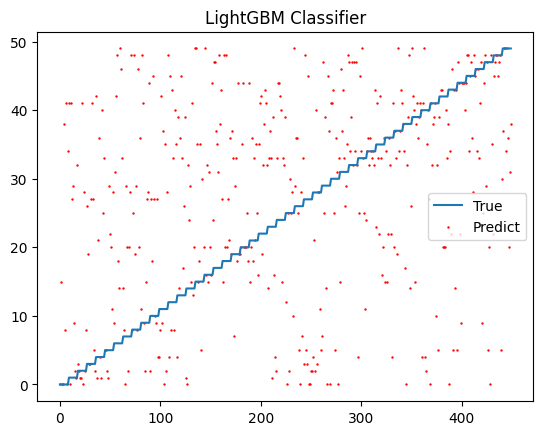

In [25]:
pred = clf.predict(test_x)
plt.title('LightGBM Classifier')
plt.plot(range(pred.shape[0]), val_y, label="True")
plt.scatter(range(pred.shape[0]), pred, label="Predict", s = 0.5, c = 'red')
plt.legend()
plt.show()

### NN

In [7]:
train_x = np.load('./data/train_x.npy')
val_x = np.load('./data/val_x.npy')
test_x = np.load('./data/test_x.npy')

In [8]:
s = time.time()

train_x_tensor = torch.tensor(train_x).to(torch.float32)
val_x_tensor = torch.tensor(val_x).to(torch.float32)
test_x_tensor = torch.tensor(test_x).to(torch.float32)

train_y_tensor = torch.tensor(train_y).to(torch.float32)
val_y_tensor = torch.tensor(val_y).to(torch.float32)
test_y_tensor = torch.tensor(test_y).to(torch.float32)

train_dataset_tensor = Data.TensorDataset(train_x_tensor, train_y_tensor)
val_dataset_tensor = Data.TensorDataset(val_x_tensor, val_y_tensor)
test_dataset_tensor = Data.TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 512
train_loader = DataLoader(
    dataset = train_dataset_tensor,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4
)

val_loader = DataLoader(
    dataset = val_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4
)

test_loader = DataLoader(
    dataset = test_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4
)

print(type(train_dataset_tensor))
print(type(train_x_tensor))
print(torch.__version__)
print(time.time() - s)

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.Tensor'>
1.13.0+cu117
0.10105085372924805


In [9]:
print(train_x.shape)

(63325, 408)


In [10]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.") #可以根據輸出結果知道是否有可用的GPUa

Training on device cuda.


In [11]:
class NNModel(nn.Module) :
    def __init__(self, n_features = 408, n_channel = 256):
        super().__init__() 
        self.n_features = n_features
        self.n_channel = n_channel
        self.fc1 = nn.Linear(n_features, n_channel)
        self.fc1_bn = nn.BatchNorm1d(n_channel)
        self.fc2 = nn.Linear(n_channel , n_channel // 2)
        self.fc2_bn = nn.BatchNorm1d(n_channel // 2)
        self.fc3 = nn.Linear(n_channel // 2, 50)
    
    def forward(self, x) :
        out = nn.functional.relu(self.fc1_bn(self.fc1(x)))
        out = nn.functional.relu(self.fc2_bn(self.fc2(out)))
        out = self.fc3(out)
        return out

In [17]:
n_features = train_x.shape[1]
print(n_features)
model = NNModel(n_features = n_features, n_channel = 256).to(device = device)
# L2 regularization
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)  
# loss_fn = nn.CrossEntropyLoss() 
# n_epochs = 100
temp = model(torch.tensor(train_x[0]))
print(temp)

408


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

In [28]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    ls_train_loss = []
    ls_train_acc = []
    ls_val_loss = []
    ls_val_acc = []
    for epoch in range(1, n_epochs + 1):
        train_acc = 0
        train_loss = 0
        val_acc = 0
        val_loss = 0
        correct = 0
        total = 0
        
        loop = tqdm(enumerate(train_loader), total = len(train_loader))
        for i, (imgs, labels) in loop : 
            imgs = imgs.to(device = device) 
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device = device)
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn(outputs, labels) 
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0] 
            correct += int((predicted == labels).sum())
            train_loss += loss.item() * labels.shape[0]
            
            loop.set_description(f'Epoch[{epoch} / {n_epochs}]')
            if (i+1 == len(train_loader)) :
                train_acc = correct / total
                train_loss /= total
                val_acc, val_loss = validate(model, loss_fn, val_loader)
            
            loop.set_postfix(loss = train_loss, acc = train_acc, val_loss = val_loss, val_acc = val_acc)
        ls_train_acc.append(train_acc)
        ls_train_loss.append(train_loss)
        ls_val_acc.append(val_acc)
        ls_val_loss.append(val_loss)
        
    return ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss
        
            
def validate(model, loss_fn, loader):
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad(): 
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device=device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0] 
            correct += int((predicted == labels).sum())
            loss += loss_fn(outputs, labels).item() * labels.shape[0]
            # print(predicted,  '\n')    
    acc = correct / total
    loss /= total
    # print("Accuracy : {:.2f}, Loss : {:.2f}".format(acc, loss)) 
        
    return acc, loss

In [14]:
s = time.time()
n_features = train_x.shape[1]
print(n_features)
model = NNModel(n_features = n_features, n_channel = 256).to(device = device)
# L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)  
loss_fn = nn.CrossEntropyLoss() 
n_epochs = 100

ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss = training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print(time.time() - s)

408


NameError: name 'training_loop' is not defined

In [30]:
torch.save(model.state_dict(), './data/nn_adam.pt')

In [31]:
n_epochs = 100
loaded_model = NNModel()
loaded_model.load_state_dict(torch.load('./data/nn_adam.pt'))
loaded_model.to(device)


NNModel(
  (fc1): Linear(in_features=408, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc2_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=50, bias=True)
)

In [46]:
print('訓練集 top 1 acc : ', round(top_n_acc(prob = loaded_model(train_x_tensor.to(device)).cpu().detach().numpy(), label = train_y, n = 1), 4))
print('驗證集 top 1 acc : ', round(top_n_acc(prob = loaded_model(val_x_tensor.to(device)).cpu().detach().numpy(), label = val_y, n = 1), 4))
print('測試集 top 1 acc : ', round(top_n_acc(prob = loaded_model(test_x_tensor.to(device)).cpu().detach().numpy(), label = test_y, n = 1), 4))

訓練集 top 1 acc :  0.2547
驗證集 top 1 acc :  0.1511
測試集 top 1 acc :  0.16


In [ ]:
print('訓練集 top 5 acc : ', round(top_n_acc(prob = loaded_model(train_x_tensor.to(device)).cpu().detach().numpy(), label = train_y, n = 5), 4))
print('驗證集 top 5 acc : ', round(top_n_acc(prob = loaded_model(val_x_tensor.to(device)).cpu().detach().numpy(), label = val_y, n = 5), 4))
print('測試集 top 5 acc : ', round(top_n_acc(prob = loaded_model(test_x_tensor.to(device)).cpu().detach().numpy(), label = test_y, n = 5), 4))

訓練集 top 5 acc :  0.5688
驗證集 top 5 acc :  0.42
測試集 top 5 acc :  0.4111


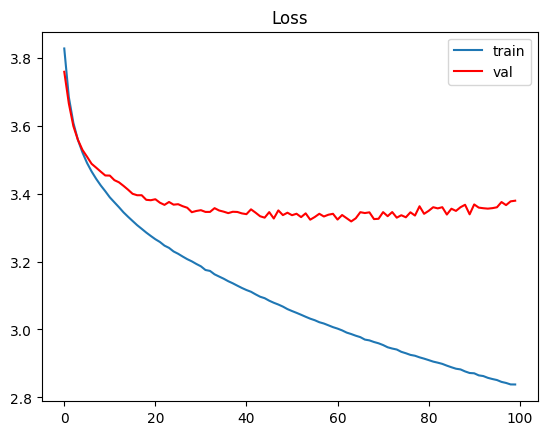

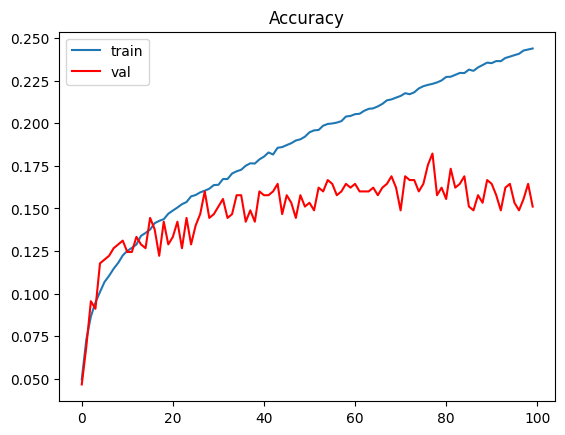

In [50]:
# plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('nn_loss.png')
plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('nn_acc.png')
plt.show()

/tmp/ipykernel_3559242/3803311950.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./pictures/nn_loss.png')
/tmp/ipykernel_3559242/3803311950.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./pictures/nn_acc.png')


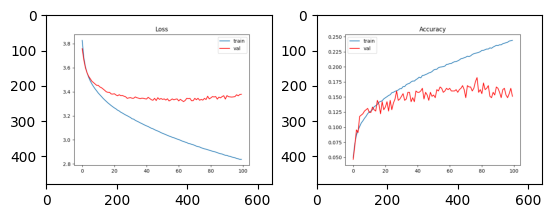

In [66]:
plt.subplot(1, 2, 1)
img = imread('./pictures/nn_loss.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./pictures/nn_acc.png')
plt.imshow(img)

### CNN

In [32]:
# 20 s
s = time.time()
train_pic = np.load('./data/train_pic.npy')
val_pic = np.load('./data/val_pic.npy')
test_pic = np.load('./data/test_pic.npy')
print(time.time() - s)

6.3615217208862305


In [33]:
s = time.time()

train_x = train_pic
val_x = val_pic
test_x = test_pic

train_x_tensor = torch.tensor(train_x).to(torch.float32)
val_x_tensor = torch.tensor(val_x).to(torch.float32)
test_x_tensor = torch.tensor(test_x).to(torch.float32)

train_x_tensor = torch.permute(train_x_tensor, (0, 3, 1, 2))
val_x_tensor = torch.permute(val_x_tensor, (0, 3, 1, 2))
test_x_tensor = torch.permute(test_x_tensor, (0, 3, 1, 2))

train_y_tensor = torch.tensor(train_y).to(torch.float32)
val_y_tensor = torch.tensor(val_y).to(torch.float32)
test_y_tensor = torch.tensor(test_y).to(torch.float32)

train_dataset_tensor = Data.TensorDataset(train_x_tensor, train_y_tensor)
val_dataset_tensor = Data.TensorDataset(val_x_tensor, val_y_tensor)
test_dataset_tensor = Data.TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 512
train_loader = DataLoader(
    dataset = train_dataset_tensor,
    batch_size = batch_size,
    shuffle = True,
    # num_workers = 4
)

val_loader = DataLoader(
    dataset = val_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    # num_workers = 4
)

test_loader = DataLoader(
    dataset = test_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    # num_workers = 4
)

print(type(train_dataset_tensor))
print(type(train_x_tensor))
print(torch.__version__)
print(time.time() - s)

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.Tensor'>
1.13.0+cu117
5.437950134277344


In [34]:
class CNNModel(nn.Module) :
    def __init__(self, n_channel = 128):
        super().__init__() # (256, 256, 3)(3, 256, 256)
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(3, n_channel, kernel_size = 3, padding = 1) # (64, 256, 256)
        self.conv1_bn = nn.BatchNorm2d(n_channel)
        self.conv2 = nn.Conv2d(n_channel, n_channel // 2, kernel_size = 3, padding = 1) # (16, 128, 128)
        self.conv2_bn = nn.BatchNorm2d(n_channel // 2)
        self.conv3 = nn.Conv2d(n_channel // 2, n_channel // 4, kernel_size = 3, padding = 1) # (8, 64, 64)
        self.conv3_bn = nn.BatchNorm2d(n_channel // 4)
        self.conv4 = nn.Conv2d(n_channel // 4, 4, kernel_size = 3, padding = 1) # (4, 32, 32)
        self.conv4_bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(4 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 50)
    
    def forward(self, x) :
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # (32, 128, 128)
        out = nn.functional.relu(self.conv1_bn(out))
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # (16, 64, 64)
        out = nn.functional.relu(self.conv2_bn(out))
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2) # (8, 32, 32)
        out = nn.functional.relu(self.conv3_bn(out))
        out = F.max_pool2d(torch.tanh(self.conv4(out)), 2) # (4, 16, 16)
        out = nn.functional.relu(self.conv4_bn(out))
        out = out.view(out.size(0), -1)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
         

In [35]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [55]:
s = time.time()
model = CNNModel(n_channel = 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  
loss_fn = nn.CrossEntropyLoss() 
n_epochs = 20

ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss = training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print(time.time() - s)

Epoch[20 / 20]: 100%|██████████| 124/124 [01:22<00:00,  1.50it/s, acc=0.412, loss=2.03, val_acc=0.271, val_loss=2.61]

1679.0601615905762


In [38]:
torch.save(model.state_dict(), './data/cnn_adam_v1.pt')

In [39]:
loaded_model = CNNModel()
loaded_model.load_state_dict(torch.load('./data/cnn_adam_v1.pt'))
loaded_model.to(device)

CNNModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
)

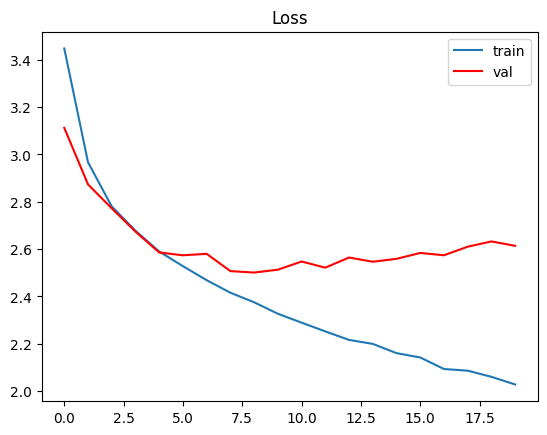

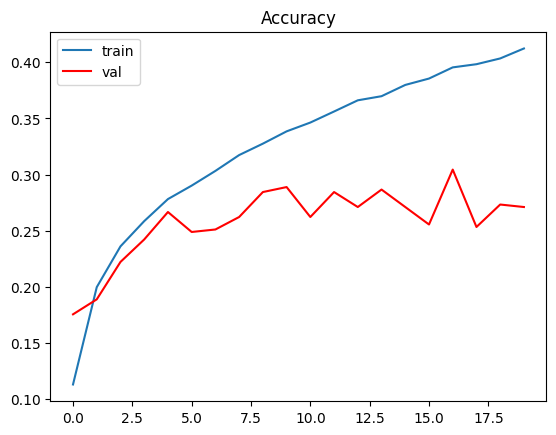

In [58]:
# plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('cnn_whole_loss.png')
plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('cnn_whole_acc.png')
plt.show()

/tmp/ipykernel_3559242/2267755869.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./pictures/cnn_whole_loss.png')
/tmp/ipykernel_3559242/2267755869.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./pictures/cnn_whole_acc.png')


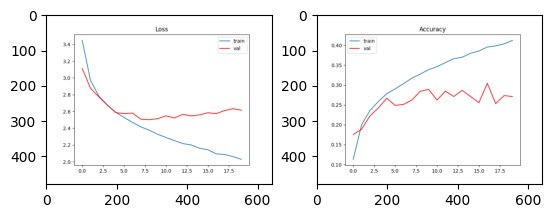

In [65]:
plt.subplot(1, 2, 1)
img = imread('./pictures/cnn_whole_loss.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./pictures/cnn_whole_acc.png')
plt.imshow(img)

### CNN for wavelet

In [41]:
train_x_wavelet = np.load('./data/train_x_wavelet.npy')
val_x_wavelet = np.load('./data/val_x_wavelet.npy')
test_x_wavelet = np.load('./data/test_x_wavelet.npy')

In [42]:
s = time.time()

train_x = train_x_wavelet
val_x = val_x_wavelet
test_x = test_x_wavelet

train_x_tensor = torch.tensor(train_x).to(torch.float32).unsqueeze(1)
val_x_tensor = torch.tensor(val_x).to(torch.float32).unsqueeze(1)
test_x_tensor = torch.tensor(test_x).to(torch.float32).unsqueeze(1)

train_dataset_tensor = Data.TensorDataset(train_x_tensor, train_y_tensor)
val_dataset_tensor = Data.TensorDataset(val_x_tensor, val_y_tensor)
test_dataset_tensor = Data.TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 512
train_loader = DataLoader(
    dataset = train_dataset_tensor,
    batch_size = batch_size,
    shuffle = True,
)

val_loader = DataLoader(
    dataset = val_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
)

test_loader = DataLoader(
    dataset = test_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
)

print(type(train_dataset_tensor))
print(type(train_x_tensor))
print(torch.__version__)
print(train_x_tensor.shape)
print(time.time() - s)

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.Tensor'>
1.13.0+cu117
torch.Size([63325, 1, 128, 128])
5.286933183670044


In [43]:
class CNNModel(nn.Module) :
    def __init__(self):
        super().__init__() # (1, 128, 128)
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1) # (32, 128, 128)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1) # (16, 64, 64)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1) # (8, 32, 32)
        self.conv3_bn = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 4, kernel_size = 3, padding = 1) # (4, 16, 16)
        self.conv4_bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(4 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 50)
    
    def forward(self, x) :
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # (32, 64, 64)
        out = self.conv1_bn(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # (16, 32, 32)
        out = self.conv2_bn(out)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2) # (8, 16, 16)
        out = self.conv3_bn(out)
        out = F.max_pool2d(torch.tanh(self.conv4(out)), 2) # (4, 8, 8)
        out = self.conv4_bn(out)
        out = out.view(out.size(0), -1)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
         

In [44]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.") #可以根據輸出結果知道是否有可用的GPUa

Training on device cuda.


In [64]:
s = time.time()
model = CNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss() 
n_epochs = 30

ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss = training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print(time.time() - s)

Epoch[30 / 30]: 100%|██████████| 124/124 [00:07<00:00, 16.44it/s, acc=0.27, loss=2.62, val_acc=0.182, val_loss=3.05]

232.06536722183228


In [47]:
torch.save(model.state_dict(), './data/cnn_wavelet_v1.pt')

In [50]:
loaded_model = CNNModel()
loaded_model.load_state_dict(torch.load('./data/cnn_wavelet_v1.pt'))
loaded_model.to(device)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
)

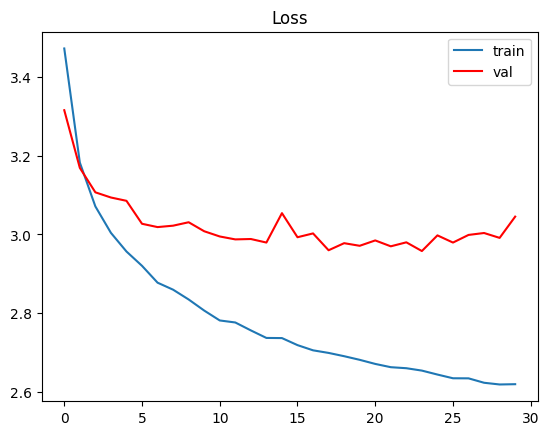

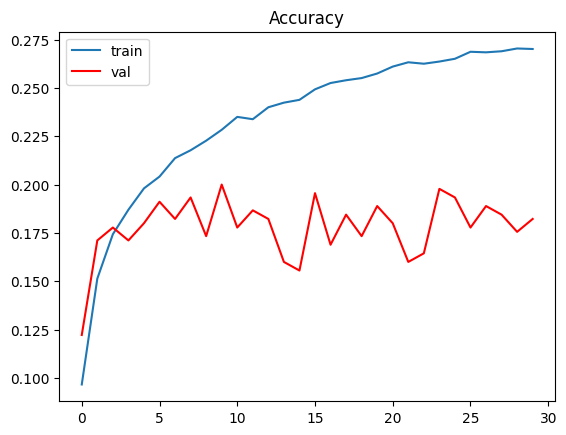

In [67]:
# plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('cnn_wavelet_loss.png')
plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('cnn_wavelet_acc.png')
plt.show()

/tmp/ipykernel_3559242/1026720217.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./pictures/cnn_wavelet_loss.png')
/tmp/ipykernel_3559242/1026720217.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./pictures/cnn_wavelet_acc.png')


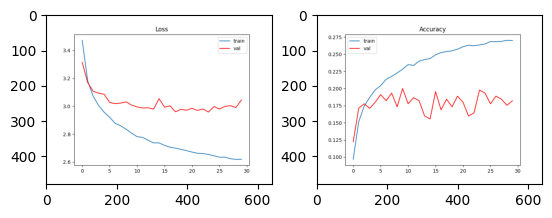

In [64]:
plt.subplot(1, 2, 1)
img = imread('./pictures/cnn_wavelet_loss.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./pictures/cnn_wavelet_acc.png')
plt.imshow(img)

In [5]:
train_x = np.load('./data/train_x.npy')
val_x = np.load('./data/val_x.npy')
test_x = np.load('./data/test_x.npy')

In [8]:
##NeuralNetMLP+
class NeuralNetMLP(object):
	""" Feedforward neural network / Multi-layer perceptron classifier.
	Parameters
	------------
	n_output : int
		Number of output units, should be equal to the
		number of unique class labels.
	n_features : int
		Number of features (dimensions) in the target dataset.
		Should be equal to the number of columns in the X array.
	n_hidden : int (default: 30)
		Number of hidden units.
	l1 : float (default: 0.0)
		Lambda value for L1-regularization.
		No regularization if l1=0.0 (default)
	l2 : float (default: 0.0)
		Lambda value for L2-regularization.
		No regularization if l2=0.0 (default)
	epochs : int (default: 500)
		Number of passes over the training set.
	eta : float (default: 0.001)
		Learning rate.
	alpha : float (default: 0.0)
		Momentum constant. Factor multiplied with the
		gradient of the previous epoch t-1 to improve
		learning speed
		w(t) := w(t) - (grad(t) + alpha*grad(t-1))
	decrease_const : float (default: 0.0)
		Decrease constant. Shrinks the learning rate
		after each epoch via eta / (1 + epoch*decrease_const)
	shuffle : bool (default: True)
		Shuffles training data every epoch if True to prevent circles.
	minibatches : int (default: 1)
		Divides training data into k minibatches for efficiency.
		Normal gradient descent learning if k=1 (default).
	random_state : int (default: None)
		Set random state for shuffling and initializing the weights.
	Attributes
	-----------
	cost_ : list
	  Sum of squared errors after each epoch.
	"""
	def __init__(self, n_output, n_features, n_hidden=30,
				 l1=0.0, l2=0.0, epochs=500, eta=0.001,
				 alpha=0.0, decrease_const=0.0, shuffle=True,
				 minibatches=1, random_state=None):

		np.random.seed(random_state)
		self.n_output = n_output
		self.n_features = n_features
		self.n_hidden = n_hidden
		self.w1, self.w2 = self._initialize_weights()
		self.l1 = l1
		self.l2 = l2
		self.epochs = epochs
		self.eta = eta
		self.alpha = alpha
		self.decrease_const = decrease_const
		self.shuffle = shuffle
		self.minibatches = minibatches

	def _encode_labels(self, y, k):
		"""Encode labels into one-hot representation
		Parameters
		------------
		y : array, shape = [n_samples]
			Target values.
		Returns
		-----------
		onehot : array, shape = (n_labels, n_samples)
		"""
		onehot = np.zeros((k, y.shape[0]))
		for idx, val in enumerate(y):
			onehot[val, idx] = 1.0
		return onehot

	def _initialize_weights(self):
		"""Initialize weights with small random numbers."""
		w1 = np.random.uniform(-1.0, 1.0,
							   size=self.n_hidden*(self.n_features + 1))
		w1 = w1.reshape(self.n_hidden, self.n_features + 1)
		w2 = np.random.uniform(-1.0, 1.0,
							   size=self.n_output*(self.n_hidden + 1))
		w2 = w2.reshape(self.n_output, self.n_hidden + 1)
		return w1, w2

	def _sigmoid(self, z):
		"""Compute logistic function (sigmoid)
		Uses scipy.special.expit to avoid overflow
		error for very small input values z.
		"""
		# return 1.0 / (1.0 + np.exp(-z))
		return expit(z)

	def _sigmoid_gradient(self, z):
		"""Compute gradient of the logistic function"""
		sg = self._sigmoid(z)
		return sg * (1.0 - sg)

	def _add_bias_unit(self, X, how='column'):
		"""Add bias unit (column or row of 1s) to array at index 0"""
		if how == 'column':
			X_new = np.ones((X.shape[0], X.shape[1] + 1))
			X_new[:, 1:] = X
		elif how == 'row':
			X_new = np.ones((X.shape[0] + 1, X.shape[1]))
			X_new[1:, :] = X
		else:
			raise AttributeError('`how` must be `column` or `row`')
		return X_new

	def _feedforward(self, X, w1, w2):
		"""Compute feedforward step
		Parameters
		-----------
		X : array, shape = [n_samples, n_features]
			Input layer with original features.
		w1 : array, shape = [n_hidden_units, n_features]
			Weight matrix for input layer -> hidden layer.
		w2 : array, shape = [n_output_units, n_hidden_units]
			Weight matrix for hidden layer -> output layer.
		Returns
		----------
		a1 : array, shape = [n_samples, n_features+1]
			Input values with bias unit.
		z2 : array, shape = [n_hidden, n_samples]
			Net input of hidden layer.
		a2 : array, shape = [n_hidden+1, n_samples]
			Activation of hidden layer.
		z3 : array, shape = [n_output_units, n_samples]
			Net input of output layer.
		a3 : array, shape = [n_output_units, n_samples]
			Activation of output layer.
		"""
		a1 = self._add_bias_unit(X, how='column')
		z2 = w1.dot(a1.T)
		a2 = self._sigmoid(z2)
		a2 = self._add_bias_unit(a2, how='row')
		z3 = w2.dot(a2)
		a3 = self._sigmoid(z3)
		return a1, z2, a2, z3, a3

	def _L2_reg(self, lambda_, w1, w2):
		"""Compute L2-regularization cost"""
		return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
								np.sum(w2[:, 1:] ** 2))

	def _L1_reg(self, lambda_, w1, w2):
		"""Compute L1-regularization cost"""
		return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
								np.abs(w2[:, 1:]).sum())

	def _get_cost(self, y_enc, output, w1, w2):
		"""Compute cost function.
		Parameters
		----------
		y_enc : array, shape = (n_labels, n_samples)
			one-hot encoded class labels.
		output : array, shape = [n_output_units, n_samples]
			Activation of the output layer (feedforward)
		w1 : array, shape = [n_hidden_units, n_features]
			Weight matrix for input layer -> hidden layer.
		w2 : array, shape = [n_output_units, n_hidden_units]
			Weight matrix for hidden layer -> output layer.
		Returns
		---------
		cost : float
			Regularized cost.
		"""
		term1 = -y_enc * (np.log(output))
		term2 = (1.0 - y_enc) * np.log(1.0 - output)
		cost = np.sum(term1 - term2)
		L1_term = self._L1_reg(self.l1, w1, w2)
		L2_term = self._L2_reg(self.l2, w1, w2)
		cost = cost + L1_term + L2_term
		return cost

	def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
		""" Compute gradient step using backpropagation.
		Parameters
		------------
		a1 : array, shape = [n_samples, n_features+1]
			Input values with bias unit.
		a2 : array, shape = [n_hidden+1, n_samples]
			Activation of hidden layer.
		a3 : array, shape = [n_output_units, n_samples]
			Activation of output layer.
		z2 : array, shape = [n_hidden, n_samples]
			Net input of hidden layer.
		y_enc : array, shape = (n_labels, n_samples)
			one-hot encoded class labels.
		w1 : array, shape = [n_hidden_units, n_features]
			Weight matrix for input layer -> hidden layer.
		w2 : array, shape = [n_output_units, n_hidden_units]
			Weight matrix for hidden layer -> output layer.
		Returns
		---------
		grad1 : array, shape = [n_hidden_units, n_features]
			Gradient of the weight matrix w1.
		grad2 : array, shape = [n_output_units, n_hidden_units]
			Gradient of the weight matrix w2.
		"""
		# backpropagation
		sigma3 = a3 - y_enc
		z2 = self._add_bias_unit(z2, how='row')
		sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
		sigma2 = sigma2[1:, :]
		grad1 = sigma2.dot(a1)
		grad2 = sigma3.dot(a2.T)

		# regularize
		grad1[:, 1:] += self.l2 * w1[:, 1:]
		grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
		grad2[:, 1:] += self.l2 * w2[:, 1:]
		grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

		return grad1, grad2

	def predict(self, X):
		"""Predict class labels
		Parameters
		-----------
		X : array, shape = [n_samples, n_features]
			Input layer with original features.
		Returns:
		----------
		y_pred : array, shape = [n_samples]
			Predicted class labels.
		"""
		if len(X.shape) != 2:
			raise AttributeError('X must be a [n_samples, n_features] array.\n'
								 'Use X[:,None] for 1-feature classification,'
								 '\nor X[[i]] for 1-sample classification')

		a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
		y_pred = np.argmax(z3, axis=0)
		return y_pred

	def fit(self, X, y, print_progress=False):
		""" Learn weights from training data.
		Parameters
		-----------
		X : array, shape = [n_samples, n_features]
			Input layer with original features.
		y : array, shape = [n_samples]
			Target class labels.
		print_progress : bool (default: False)
			Prints progress as the number of epochs
			to stderr.
		Returns:
		----------
		self
		"""
		self.cost_ = []
		X_data, y_data = X.copy(), y.copy()
		y_enc = self._encode_labels(y, self.n_output)

		delta_w1_prev = np.zeros(self.w1.shape)
		delta_w2_prev = np.zeros(self.w2.shape)

		for i in range(self.epochs):

			# adaptive learning rate
			self.eta /= (1 + self.decrease_const*i)

			if print_progress:
				sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
				sys.stderr.flush()

			if self.shuffle:
				idx = np.random.permutation(y_data.shape[0])
				X_data, y_enc = X_data[idx], y_enc[:, idx]

			mini = np.array_split(range(y_data.shape[0]), self.minibatches)
			for idx in mini:

				# feedforward
				a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
													   self.w1,
													   self.w2)
				cost = self._get_cost(y_enc=y_enc[:, idx],
									  output=a3,
									  w1=self.w1,
									  w2=self.w2)
				self.cost_.append(cost)

				# compute gradient via backpropagation
				grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
												  a3=a3, z2=z2,
												  y_enc=y_enc[:, idx],
												  w1=self.w1,
												  w2=self.w2)

				delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
				self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
				self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
				delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

		return self
##NeuralNetMLP-



# X_train, y_train = load_mnist('mnist', kind='train')   #X_train=60000x784
# X_test, y_test = load_mnist('mnist', kind='t10k')					 #X_test=10000x784

# ##load data+	
# train_data,train_label=loadTrainData()	
# train_label=train_label.reshape(train_data.shape[0]).astype(int)
# print("train_data.shape=",train_data.shape)
# print("train_label.shape=",train_label.shape)
# print("train_label=",train_label)
# test_data=loadTestData()	
# print("test_data.shape=",test_data.shape)
##load data-	
##宣告NeuralNetMLP物件 
hidden_num=100
nn = NeuralNetMLP(n_output=10, 
				  n_features=train_x.shape[1], 
				  n_hidden=hidden_num, 
				  l2=0.3, 
				  l1=0.0, 
				  epochs=1000, 
				  eta=0.002,
				  alpha=0.001,
				  decrease_const=0.00001,
				  minibatches=100, 
				  shuffle=True,
				  random_state=1)

#訓練樣本+
nn.fit(train_x, train_y, print_progress=True)
train_pred = nn.predict(train_x)
acc = np.sum(train_y == train_pred, axis=0) / train_x.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

#預測測試樣本1
train_pred2 = nn.predict(test_x)
acc = np.sum(test_y == train_pred2, axis=0) / test_x.shape[0]
print('test1 accuracy: %.2f%%' % (acc * 100))



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices